# 1. Setup

In [1]:
import plotly.express as px
from scipy.optimize import curve_fit

from utils import *

# 2. Prepare data for Indianapolis

In [2]:
inroot = Path('../../access/data')
outroot = mkdir('../data/access')

## 2.1. Zones

In [3]:
def get_zones(overwrite=False):
    outpath = outroot / 'zones/indianapolis.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    df = gpd.read_parquet(inroot / 'zones/msa_2010.parquet', filters=[
        ('region', '==', 'indianapolis'), ('scale', '==', 'bg')])
    df['cnty_id'] = df.geoid.str[:5]
    cnty = pd.read_parquet(inroot / 'zones/us/county_2010.parquet', columns=[
        'geoid', 'name']).rename(columns=D(geoid='cnty_id', name='county'))
    df = df.merge(cnty, on='cnty_id')
    df = df[~df.county.isin(['Brown', 'Tipton', 'Madison'])]
    popu = pd.read_parquet(inroot / 'ses/acs_2019.parquet', filters=[
        ('scale', '==', 'BG')], columns=['geoid', 'popu'])
    df = df.merge(popu, 'left', on='geoid').to_crs(CRS_M)
    df['pop_density'] = df['popu'].fillna(0) / (df['aland'] * SQM2SQMI)
    df = df[['geoid', 'county', 'popu', 'pop_density', 'geometry']]
    df.to_parquet(mkfile(outpath))
    return df

zones = get_zones(overwrite=1).disp()

1,030 rows x 5 cols; Memory: 0.2 MiB; <Projected CRS: EPSG:3857>


,geoid,county,popu,pop_density,geometry
,<object>,<object>,<float64>,<float64>,<geometry>
0,180118101001,Boone,1259.0,34.3504,"POLYGON ((-9632457.838543 4880105.711162, -963..."


## 2.2. SES

In [4]:
def get_ses(zones=zones):
    ses_cols = 'p_senior p_poc m_income p_unemploy p_renter m_hhperveh'.split()
    df = pd.read_parquet(outroot / 'acs_2019.parquet')
    df = zones[['geoid']].merge(df)
    df['sedi'] = df[ses_cols].apply(lambda x: x.fillna(0).rank(pct=1)).mean(1)
    df['ses'] = pd.cut(df.sedi, [-1, 0.33, 0.67, 1.1], labels=['High', 'Mid', 'Low'])
    df = df[['geoid', 'sedi', 'ses']]
    return df

ses = get_ses().disp()

1,030 rows x 3 cols; Memory: 0.1 MiB


,geoid,sedi,ses
,<object>,<float64>,<category>
0,180118101001,0.257929,High


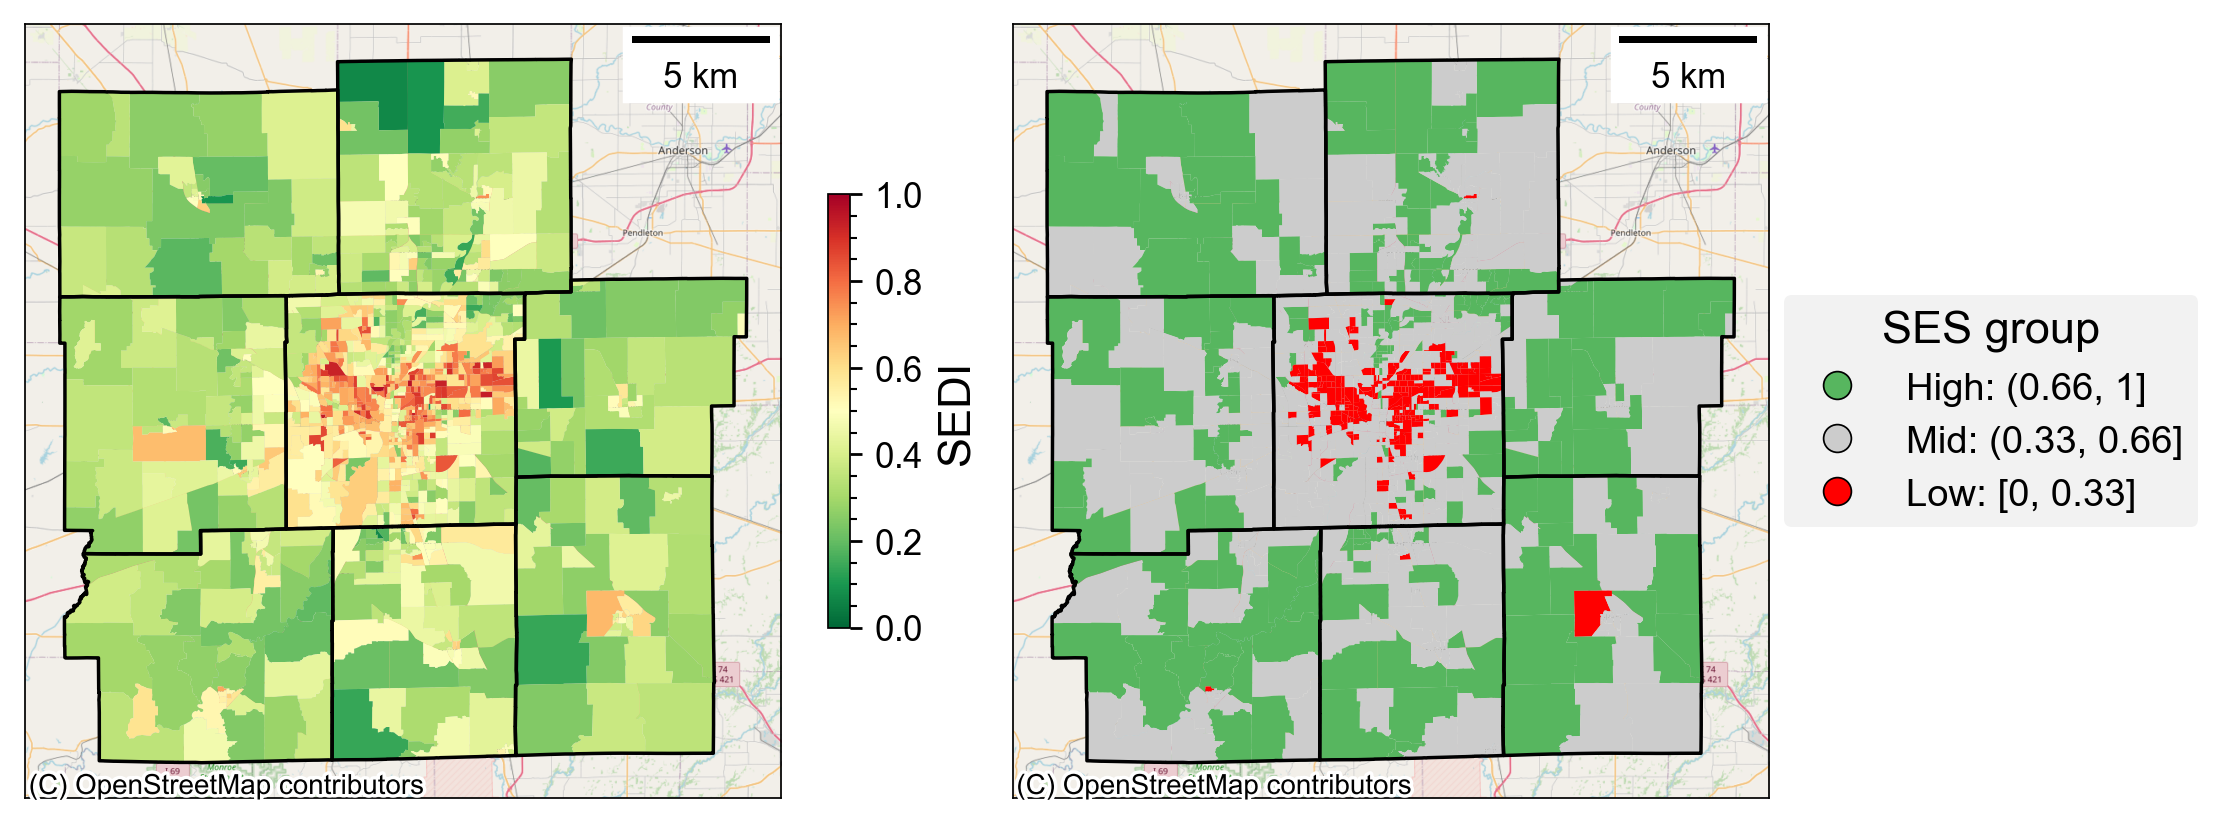

In [5]:
def fig_ses_indy(ses=ses, zones=zones, dpi=150):
    colors = D(High='#57B65F', Mid='#ccc', Low='r')
    ses = zones.merge(ses.assign(color=ses.ses.map(colors)))
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), dpi=dpi,
                                 gridspec_kw=D(width_ratios=[1, 0.8]))
    ses.plot(ax=ax1, column='sedi', cmap='RdYlGn_r', vmin=0, vmax=1,
             legend=True, legend_kwds=D(shrink=0.5, label='SEDI'))
    ses.plot(ax=ax2, color=ses.color)
    ses_labels = ['High: (0.66, 1]', 'Mid: (0.33, 0.66]', 'Low: [0, 0.33]']
    ax2.legend(loc=(1.02, 0.35), title='SES group', handles=[
        mpl.lines.Line2D([0], [0], label=x, color='none', marker='o',
                         markerfacecolor=c, markersize=8, markeredgewidth=0.5)
        for x, c in zip(ses_labels, colors.values())])
    for ax in (ax1, ax2):
        zones.dissolve('county').plot(ax=ax, fc='none', ec='k')
        basemap(ax)
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05)

fig_ses_indy(dpi=250)

## 2.3. Opportunities

In [6]:
opport = (
    pd.read_parquet(inroot / 'opport/opportunities.parquet')
    .merge(zones['geoid']).assign(purpose=lambda df: df.kind.map(
        D(total='Work', overall='Non-work')))
    [['geoid', 'purpose', 'opport']].dropna()
).disp()

1,540 rows x 3 cols; Memory: 0.2 MiB


,geoid,purpose,opport
,<object>,<object>,<int32>
0,180118101001,Work,183


## 2.4. Travel times

In [7]:
tt = (
    pd.read_parquet(inroot / 'od_cost/gdm/odp_in_2010.parquet')
    .rename(columns=D(src_geoid='src', trg_geoid='trg'))
    .merge(zones['geoid'].rename('src'))
    .merge(zones['geoid'].rename('trg'))
    .astype(D(src=CAT, trg=CAT))
    .assign(time=lambda df: df.time / 60)
    .query('time <= 90')
    .assign(mode=lambda df: pd.Categorical(
        df['mode'].str.title(), categories=[
            'Drive', 'Transit', 'Walk', 'Bike']))
    [['mode', 'src', 'trg', 'time']]
).disp()

1,734,118 rows x 4 cols; Memory: 28.3 MiB


,mode,src,trg,time
,<category>,<category>,<category>,<float32>
0,Transit,181095107012,181095108001,54.716667


In [8]:
# sns.displot(tt, x='time', hue='mode', kind='kde', fill=True, palette=sns.color_palette('bright')[:4], height=3);

### 2.4.1. Impedance function params
Taken from the results of `2_select_factors.ipynb`.

In [9]:
params = Pdf([
    ('Overall', 'Overall', 0.054),
    ('Mode', 'Drive', 0.055),
    ('Mode', 'Transit', 0.020),
    ('Mode', 'Walk', 0.060),
    ('Mode', 'Bike', 0.046),
    ('Purpose', 'Work', 0.038),
    ('Purpose', 'Non-work', 0.058),
    ('SES', 'Low', 0.046),
    ('SES', 'Mid', 0.056),
    ('SES', 'High', 0.053),
], columns=['factor', 'level', 'beta']).disp()

10 rows x 3 cols; Memory: 0.0 MiB


,factor,level,beta
,<object>,<object>,<float64>
0,Overall,Overall,0.054


## 2.5. Compute accessibility

In [10]:
def get_access_bg(opport=opport, tt=tt, ses=ses, params=params, zones=zones):
    beta0 = params.iloc[0].beta
    opp_poi = opport.query('purpose=="Non-work"')
    tt = tt.rename(columns=D(trg='geoid'))
    tt_drive = tt.query('mode=="Drive"')
    def f(df, factor, level):
        beta = params.query(f'factor=="{factor}" & level=="{level}"')
        df['general'] = df.opport * np.exp(-beta0 * df.time)
        df['case'] = df.opport * np.exp(-beta.iloc[0].beta * df.time)
        df = df.groupby('src')[['general', 'case']].sum().reset_index()
        return df.assign(factor=factor, level=level)
    res = []
    for mode, df in tt.groupby('mode'):
        res.append(f(df.merge(opp_poi), 'Mode', mode))
    for purp, df in opport.groupby('purpose'):
        res.append(f(tt_drive.merge(df), 'Purpose', purp))
    for ses_cat, df in ses.groupby('ses'):
        res.append(f(opp_poi.merge(df).merge(tt_drive), 'SES', ses_cat))
    df = pd.concat(res).rename(columns=D(src='geoid'))
    df['pct_diff'] = (df.general / (df.case + 1e-6) - 1) * 100
    df.factor, df.level = ordered_factor(df.factor), ordered_factor(df.level)
    return df

xs_bg = get_access_bg().disp()
# x = get_access_bg(); x

9,270 rows x 6 cols; Memory: 0.4 MiB


,geoid,general,case,factor,level,pct_diff
,<category>,<float64>,<float64>,<category>,<category>,<float64>
0,180118101001,2298.945851,2222.267071,Mode,Drive,3.450475


/tmp/ipykernel_209183/829729564.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


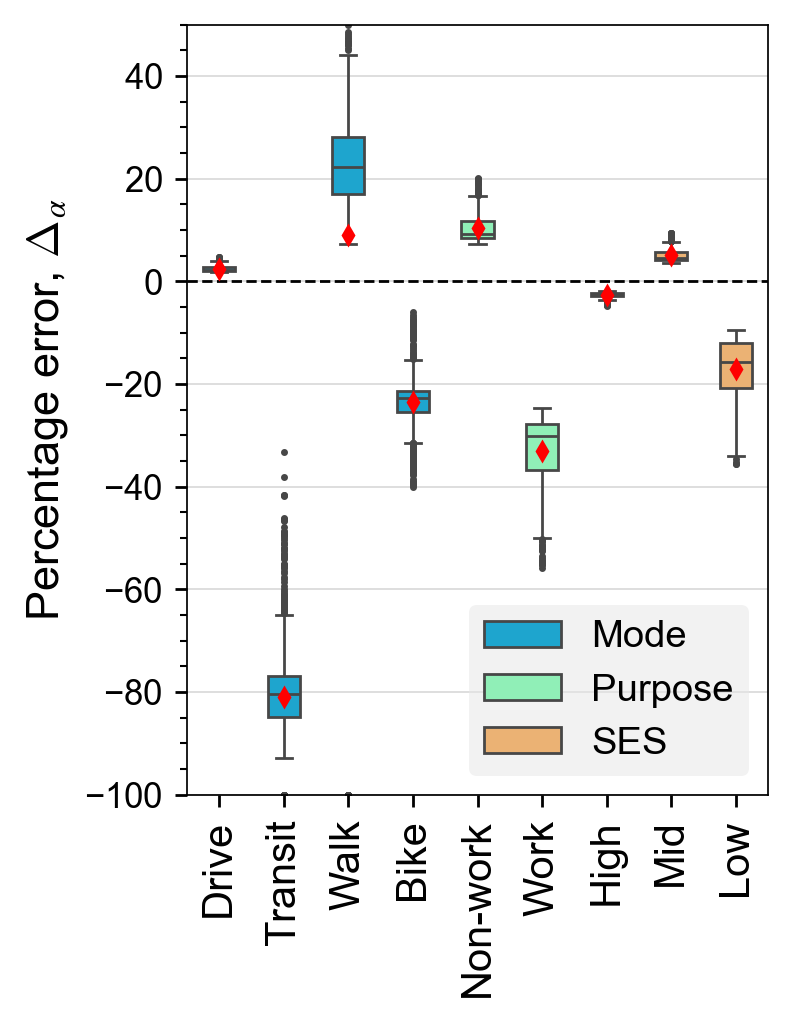

In [11]:
ax = pplot(size=(3, 4), ylim=(-100, 50), dpi=250)
sns.boxplot(xs_bg, x='level', y='pct_diff', ax=ax, linewidth=0.8,
            width=0.5, fliersize=1, hue='factor', palette='rainbow',
            showmeans=True, meanprops=D(marker='d', markerfacecolor='r',
                                        markersize=5, markeredgecolor='none'))
ax.axhline(0, ls='--', color='k', lw=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.legend(handles=ax.legend().legend_handles, title='', loc='lower right')
ax = pplot(ax, xminor=0, xlab='', ylab='Percentage error, $\Delta_{α}$')

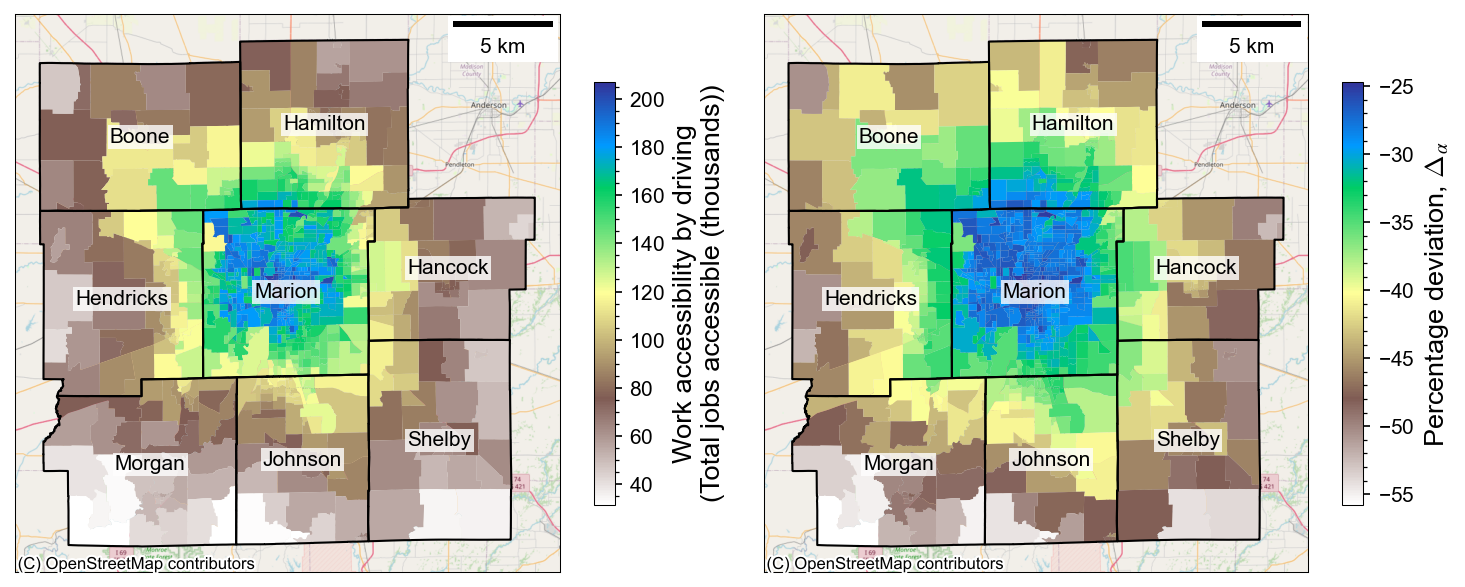

In [12]:
def fig_xs_delta_main(xs=xs_bg, zones=zones, dpi=150):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=dpi)
    df = xs.query('factor=="Purpose" & level=="Work"').copy()
    df['general'] /= 1000
    label = 'Work accessibility by driving\n(Total jobs accessible (thousands))'
    zones.merge(df).plot(ax=ax1, column='general', cmap='terrain_r',
                         legend=1, legend_kwds=D(shrink=0.6, label=label))
    label = 'Percentage deviation, $\Delta_α$'
    zones.merge(df).plot(ax=ax2, column='pct_diff', cmap='terrain_r',
                         legend=1, legend_kwds=D(shrink=0.6, label=label))
    cnty = zones.dissolve('county')
    for ax in [ax1, ax2]:
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
        basemap(ax)
        for _, r in cnty.iterrows():
            x, y = r.geometry.centroid.coords[0]
            ax.text(x, y, r.name, ha='center', va='center',
                    bbox=D(fc='w', alpha=0.8, pad=1, ec='none'))
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)

x = fig_xs_delta_main(); x

  0%|          | 0/9 [00:00<?, ?it/s]

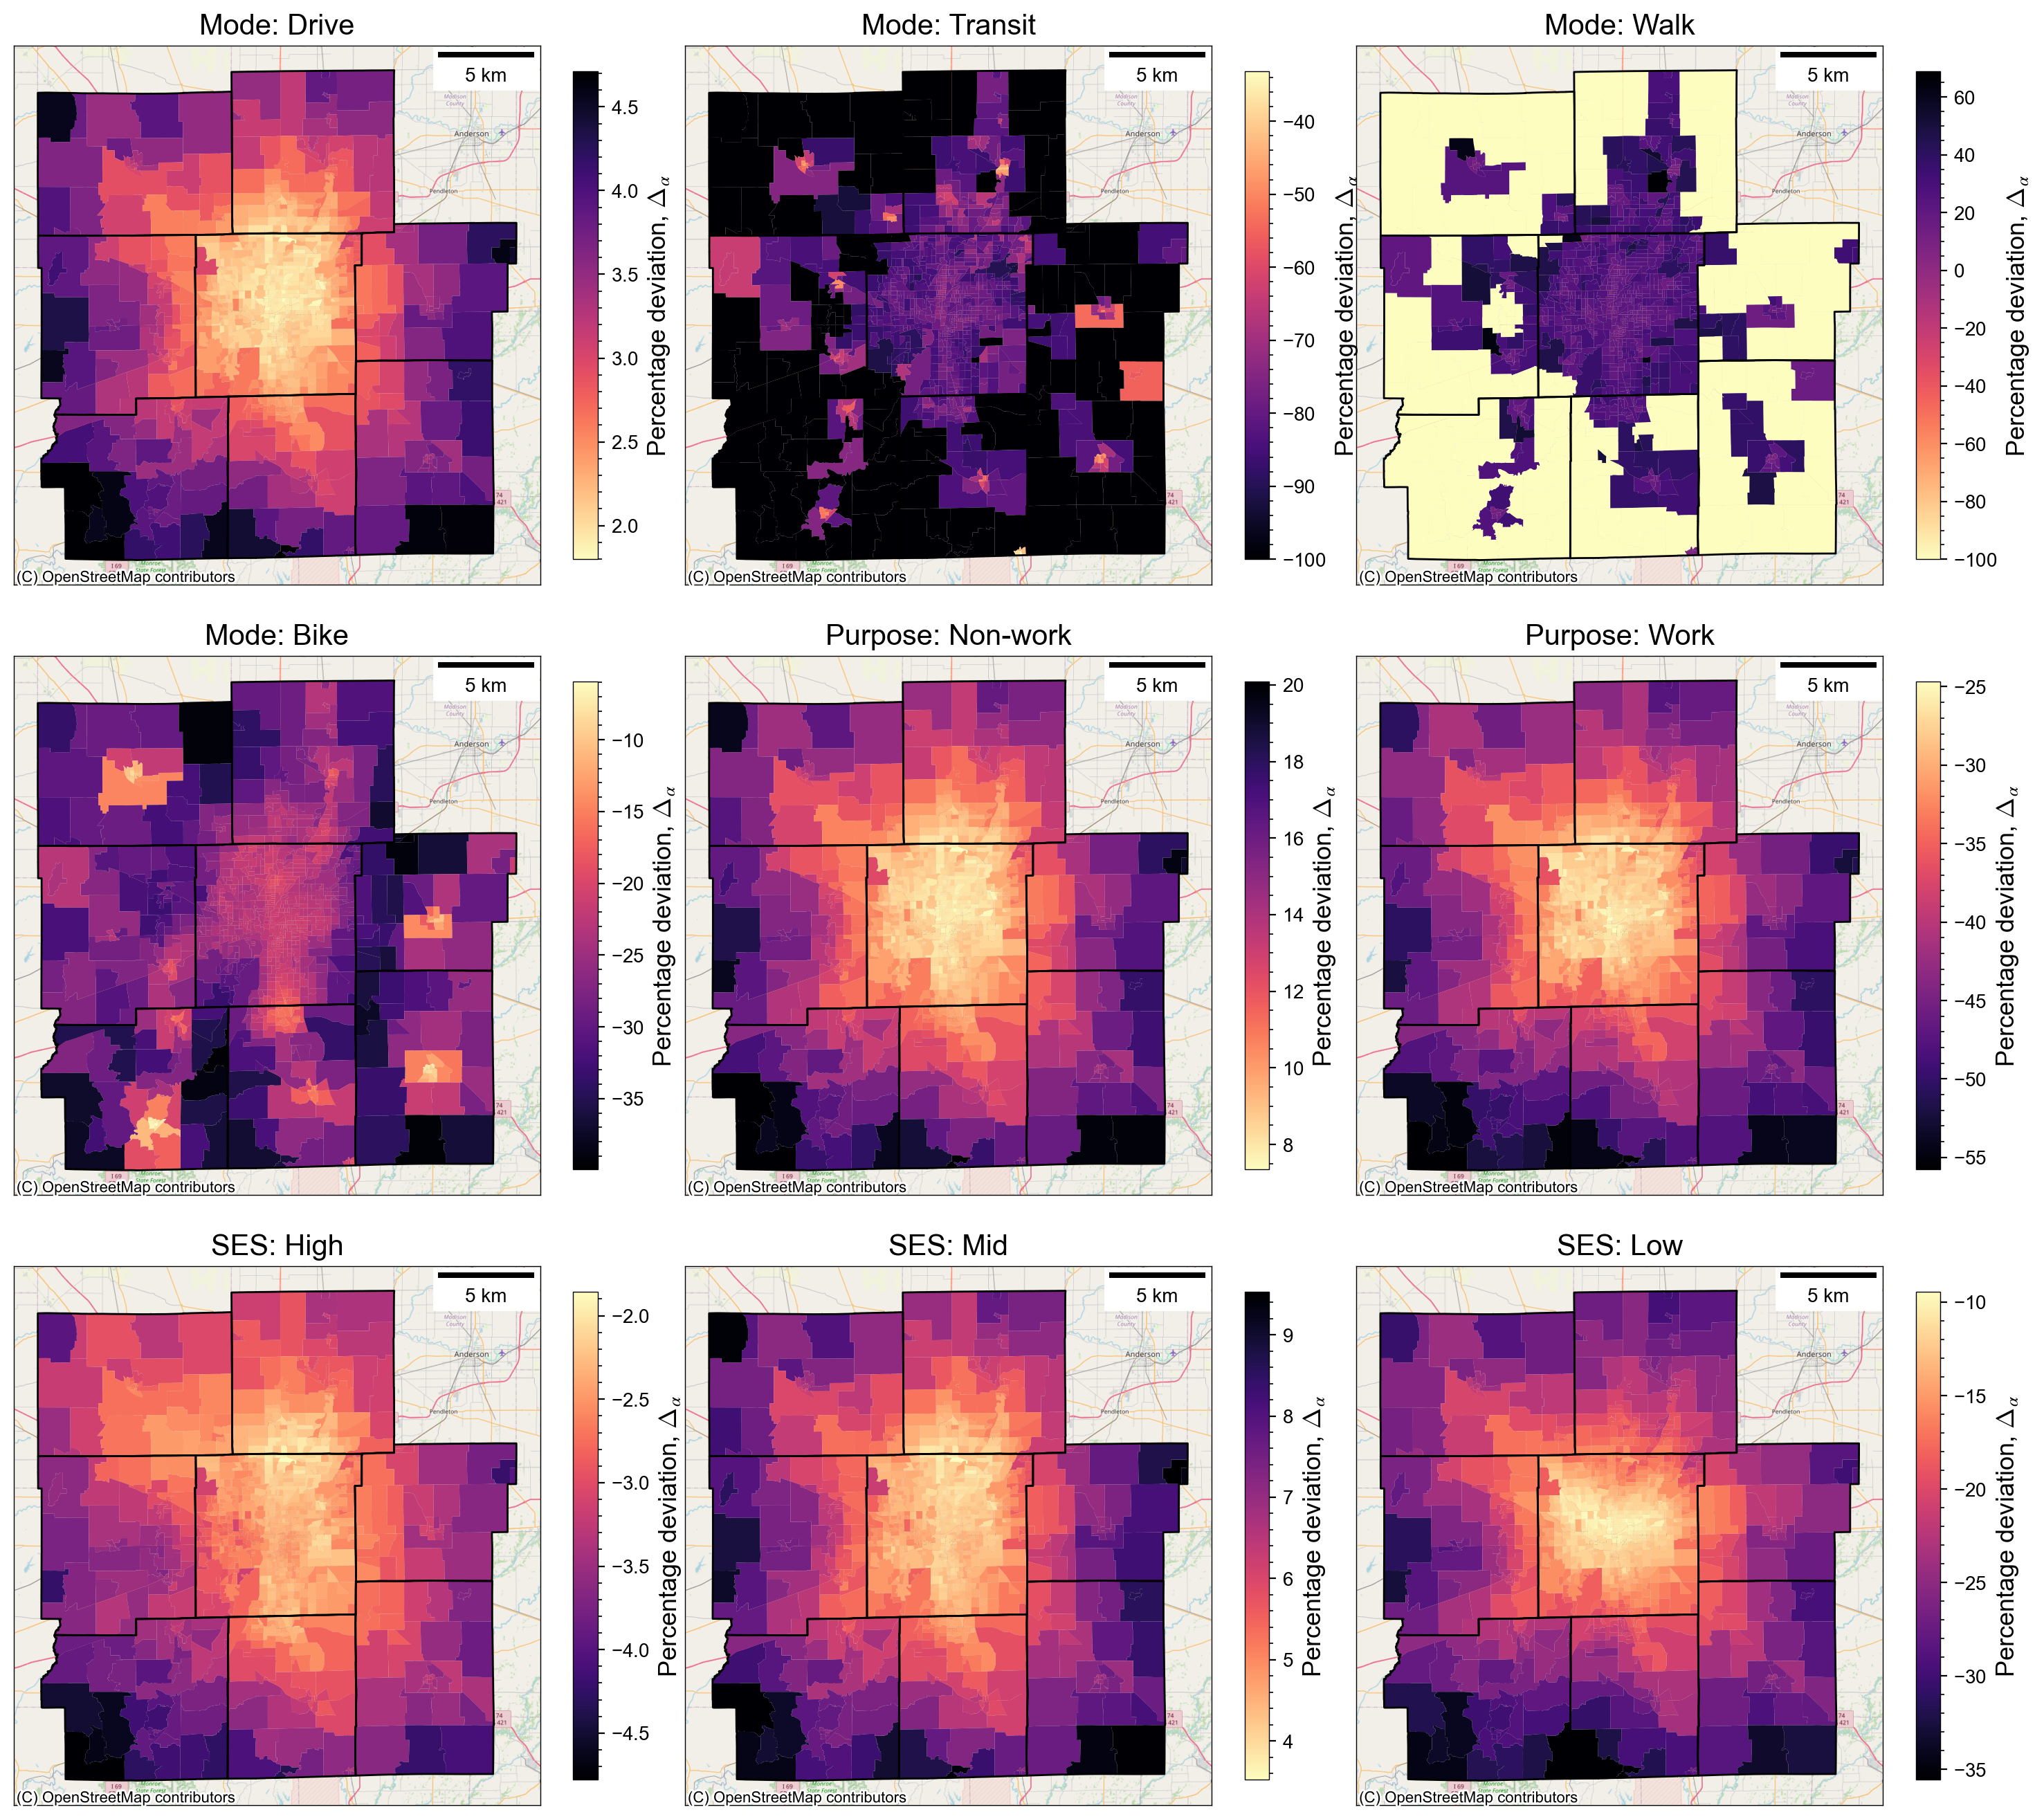

In [13]:
def fig_xs_delta_by_var(xs=xs_bg, zones=zones, dpi=100, cmap='magma'):
    _, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=dpi)
    cnty = zones.dissolve('county')
    for i, (level, df) in enumerate(tqdm(xs.groupby('level'))):
        ax = pplot(axes.flatten()[i], title=f'{df.factor.iloc[0]}: {level}')
        cmap2 = cmap + ('_r' if df.pct_diff.mean() > 0 else '')
        zones.merge(df).plot(
            ax=ax, column='pct_diff', cmap=cmap2, legend=True, legend_kwds=D(
                shrink=0.6, label='Percentage deviation, $\Delta_α$'))
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
        basemap(ax)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=-0.25)

fig_xs_delta_by_var(dpi=200) # t=0:21